# Survival Analysis in Python

Marriage and divorce data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf, Cdf, Surv, Hazard

In [2]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

Read the tables from [National Survey of Family Growth](https://www.cdc.gov/nchs/nsfg/index.htm), specifically [2015-2017 NSFG: Public-Use Data Files](https://www.cdc.gov/nchs/nsfg/nsfg_2015_2017_puf.htm)

[Here is the codebook](https://www.icpsr.umich.edu/icpsradmin/nsfg/index?studyNumber=10001)

And here are the data files we need.

[2015_2017_FemRespData.dat](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat)

[2015_2017_FemRespSetup.dct](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct)


Data User's Agreement

Federal law (The Public Health Service Act (Section 308 (d))) provides that these data may be used only for the purpose of health statistical reporting and analysis. Any effort to determine the identity of any person or establishment is prohibited by this law.

NCHS does all it can to assure that the identity of data subjects cannot be disclosed. All direct identifiers, as well as any characteristics that might lead to identification, are omitted from the data files. In addition, some records have had one or more responses slightly modified through statistical perturbation. These modifications are intended to prevent definitive identification of individual respondents. They do not affect univariate point estimates and have a minimal effect on estimates of variance and tests of statistical significance.

By downloading National Survey of Family Growth data, you signify your agreement to comply with the following legal requirements:

1. To use these data for statistical reporting and analysis only;
2. To make no use of the identity of any person or establishment discovered inadvertently and advise the Director, NCHS, of any such discovery (301-458-4500); and
3. To not link these data with individually identifiable data from any other data set.

In [3]:
import os

if not os.path.exists('2015_2017_FemRespData.dat'):
    !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat

if not os.path.exists('2015_2017_FemRespSetup.dct'):
    !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct
    

In [4]:
import utils

df = utils.read_stata('2015_2017_FemRespSetup.dct', 
                      '2015_2017_FemRespData.dat')
df.shape

(5554, 3024)

In [5]:
df.head()

,CASEID,RSCRNINF,RSCRAGE,RSCRHISP,RSCRRACE,AGE_A,AGE_R,AGESCRN,HISP,HISPGRP,...,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR,INTVLNGTH
0,70623,5,16,5.0,3.0,16,16,16,5,NaN,...,322,1390,1378,1345,1333,1321,17,1,2015,35.04
1,70624,1,40,5.0,1.0,40,40,40,5,NaN,...,331,1394,1382,1357,1345,1333,18,1,2016,61.01
2,70625,5,15,5.0,2.0,15,15,15,5,NaN,...,366,1402,1390,1357,1345,1333,21,1,2016,40.35
3,70627,1,35,5.0,3.0,35,35,35,5,NaN,...,322,1394,1382,1357,1345,1333,18,1,2016,64.79
4,70628,1,28,5.0,2.0,28,28,28,5,NaN,...,366,1409,1397,1369,1357,1345,23,1,2017,77.86


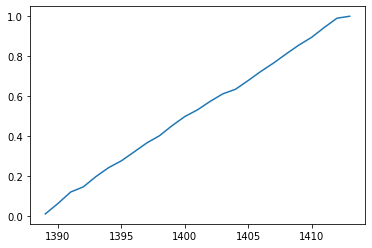

In [6]:
Cdf.from_seq(df['CMINTVW']).plot()

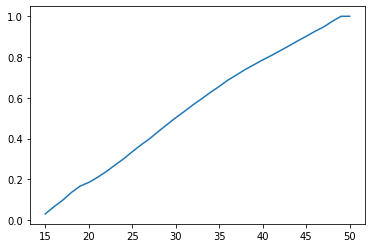

In [7]:
Cdf.from_seq(df['AGER']).plot()

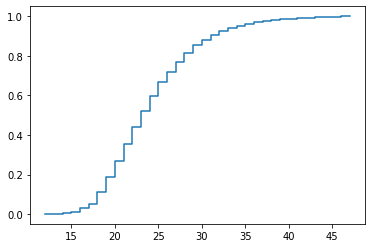

In [14]:
cdf = Cdf.from_seq(df['FMAR1AGE'])
cdf.step()

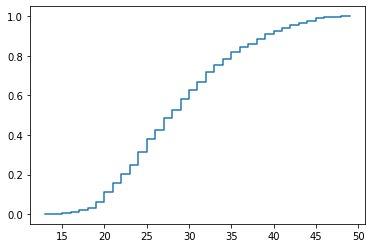

In [11]:
Cdf.from_seq(df['AGEDISS1']).step()

In [36]:
np.random.seed(17)
sample = utils.resample_rows_weighted(df, 'WGT2015_2017')

In [37]:
nsfg = pd.DataFrame(index=sample.index)

In [38]:
nsfg['cmintvw'] = sample['CMINTVW']

In [39]:
np.random.seed(17)
def jitter_age(age):
    return age*12 + np.random.randint(0, 12, size=len(age))

In [40]:
nsfg['cmbirth'] = sample['CMINTVW'] - jitter_age(sample['AGER']) 

In [41]:
nsfg['cmmarr1'] = nsfg['cmbirth'] + jitter_age(sample['FMAR1AGE'])

In [42]:
nsfg['cmdiss1'] = nsfg['cmbirth'] + jitter_age(sample['AGEDISS1'])

In [43]:
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
1641,1400,847,1161.0,NaN
2953,1409,887,1267.0,NaN
1052,1410,1188,NaN,NaN
379,1410,909,1193.0,NaN
4405,1401,1077,NaN,NaN


In [44]:
nsfg.loc[1641]

,cmintvw,cmbirth,cmmarr1,cmdiss1
1641,1400,847,1161.0,NaN
1641,1400,846,1161.0,NaN
1641,1400,843,1165.0,NaN
1641,1400,842,1159.0,NaN
1641,1400,847,1168.0,NaN
1641,1400,842,1158.0,NaN
1641,1400,845,1158.0,NaN
1641,1400,844,1158.0,NaN
1641,1400,840,1160.0,NaN
1641,1400,846,1164.0,NaN


In [45]:
df.loc[1641, ['CMINTVW', 'AGER', 'FMAR1AGE']]

CMINTVW     1400.0
AGER          46.0
FMAR1AGE      26.0
Name: 1641, dtype: float64

In [46]:
nsfg.index = range(len(nsfg))

In [47]:
if os.path.exists('nsfg.hdf5'):
    !rm nsfg.hdf5

In [48]:
nsfg.to_hdf('nsfg.hdf5', 'nsfg')

In [49]:
nsfg = pd.read_hdf('nsfg.hdf5', 'nsfg')
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
0,1400,847,1161.0,NaN
1,1409,887,1267.0,NaN
2,1410,1188,NaN,NaN
3,1410,909,1193.0,NaN
4,1401,1077,NaN,NaN
